In [1]:
# Load libraries
import numpy as np
import pandas as pd
import io
from timeit import default_timer

from sklearn.model_selection import train_test_split

# Support Vector Classifier

## Intuition

- It is a classifier in which the objective is to build an optimal **hyperplane** that separates the classes.


- The optimal hyperplane is the one that maximizes the distances from the closest point of each class.


- This reduces the possibility of misclassifying a new pattern.

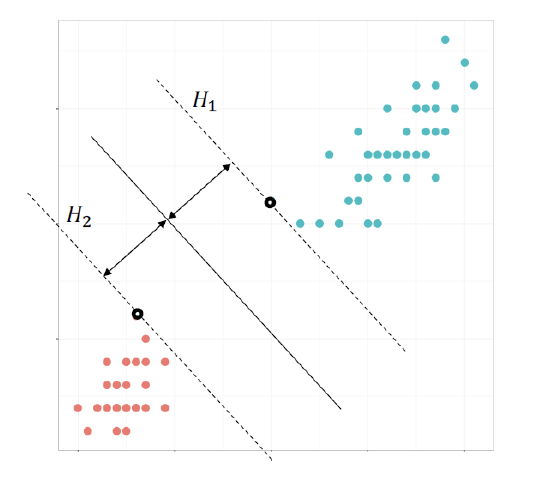

- The solution to the optimization problem of SVMs is guaranteed to **exist** and be **unique**.


- Existence is guaranteed by being the function to minimize quadratic.


- Furthermore, the uniqueness of the solution is also certain because it is a convex optimization problem.


- This is one of the main advantages of SVMs compared to models such as ANN

## Soft Margin

When the data is not perfect and has noise or the problem is complex, we cannot find a perfect linear separator.

Even if we can, it may not be recommended due to the risk of overfitting.

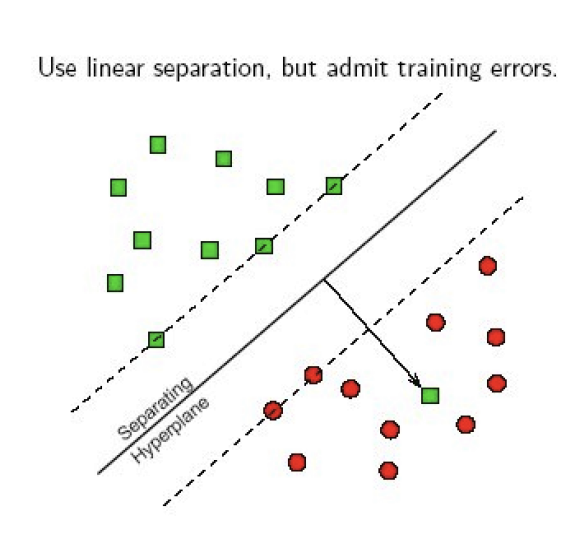

## Kernel trick

It consists of passing the data to a higher-dimensional space in which a hyperplane is built to separate them.

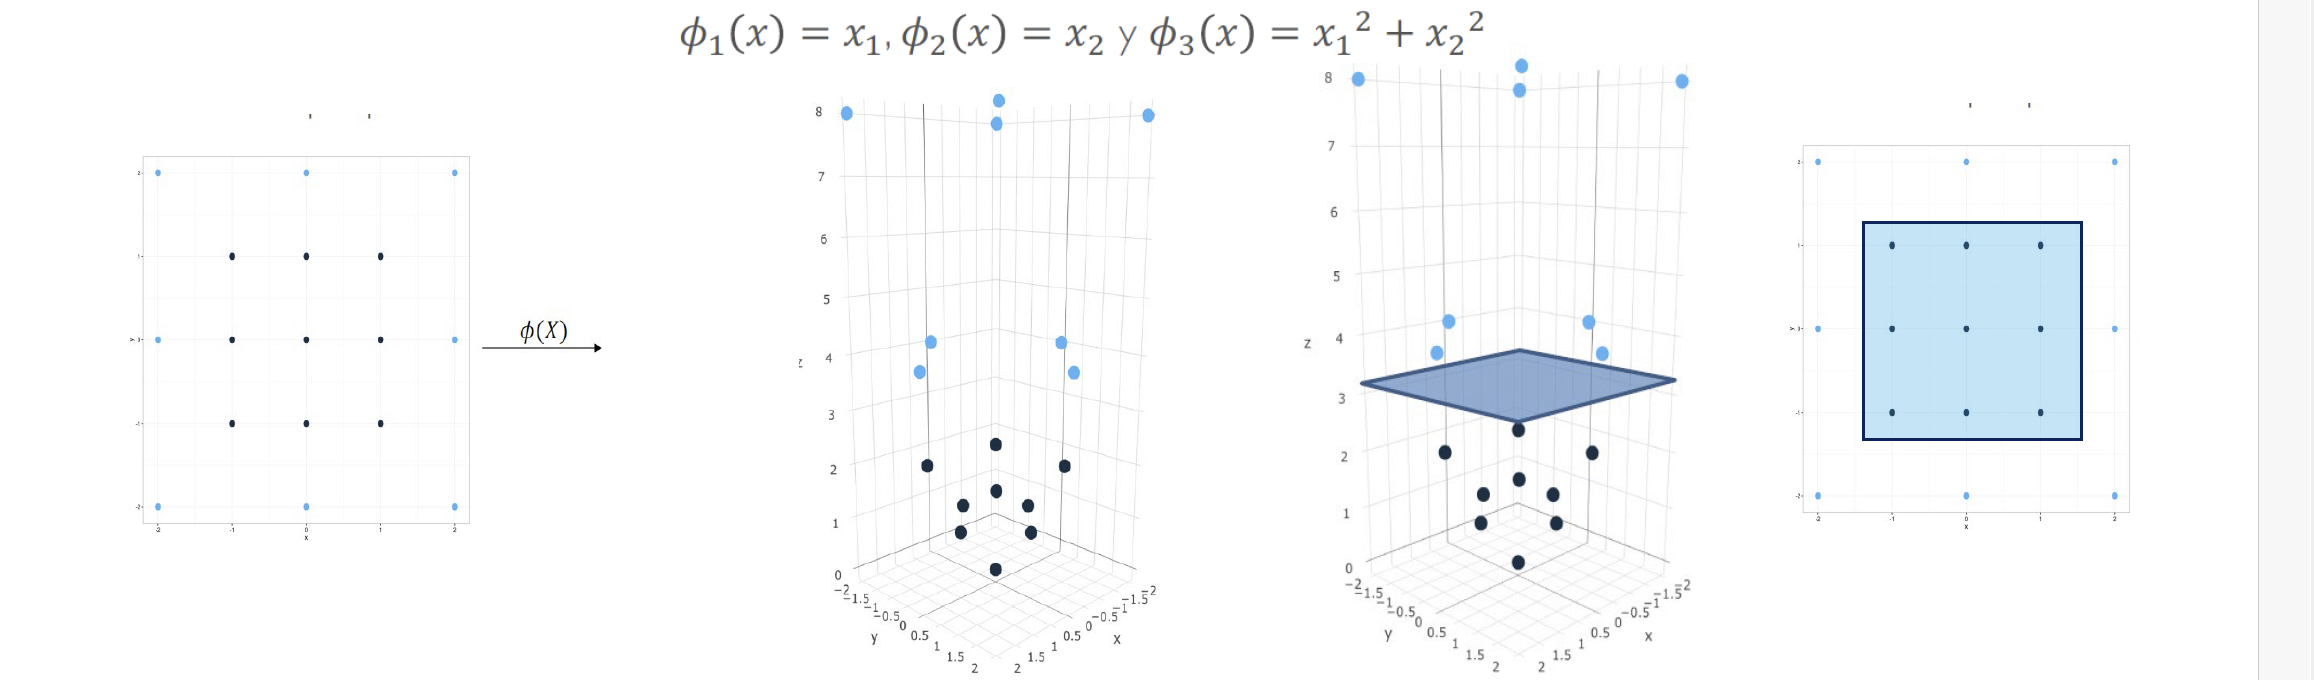

It allows for non-linear separators in the original space.

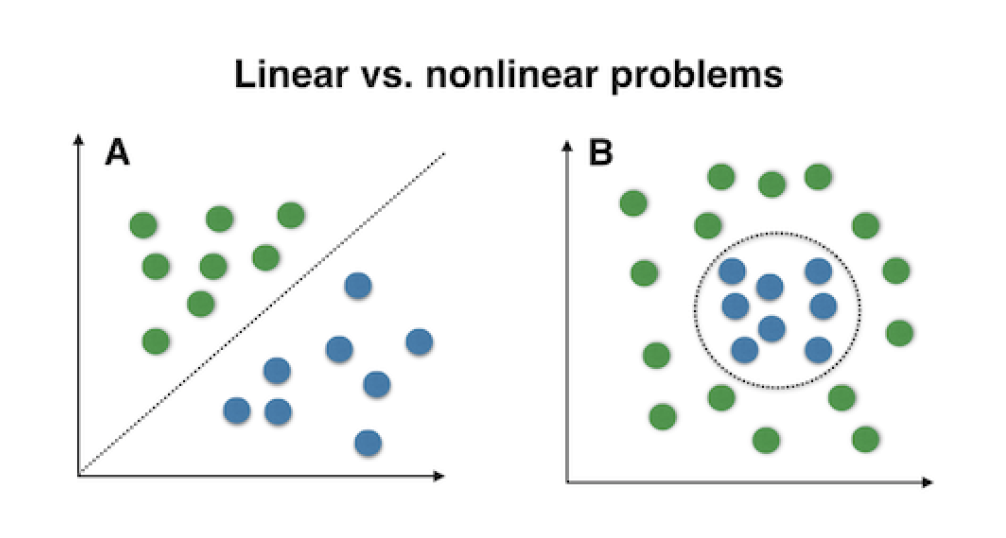

## Key Hyperparameters

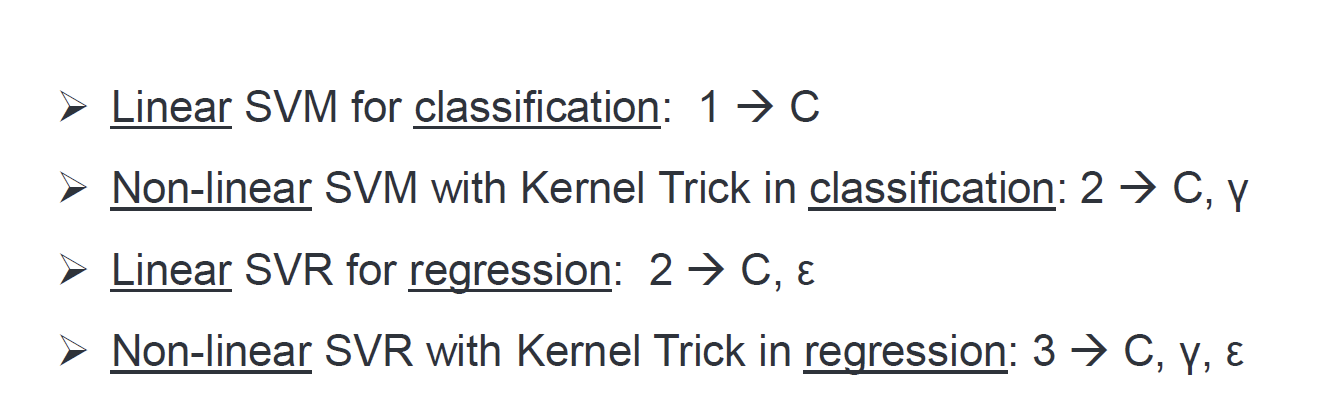

In [2]:
# [1] Import model
from sklearn.svm import SVC as model_constructor
?model_constructor

Check *C*, *gamma* and ***probability*** arguments. Where is epsilon?

## Data

In [25]:
from google.colab import files

In [26]:
uploaded = files.upload()

Saving healthcare.csv to healthcare (3).csv


In [3]:
dat = pd.read_csv('../data/healthcare.csv', sep = ";")
X = dat.drop(['exitus', 'date', 'tip_grd'], axis = 1)
X.fillna(0, inplace = True)
y = dat.exitus;

In [28]:
X

,severity,mortality_ratio,age,num_proc,ambulatory,origin,expected_length,tip_adm
0,4,0.408730,12596,21,0,1,151,1.0
1,4,0.306931,20973,22,0,1,99,1.0
2,4,0.278481,19611,19,0,1,87,1.0
3,3,0.150289,13583,22,0,1,100,1.0
4,1,0.016573,18042,2,0,1,44,1.0
...,...,...,...,...,...,...,...,...
32701,2,0.028365,23619,2,0,1,2,1.0
32702,1,0.000606,3935,1,0,1,2,1.0
32703,2,0.040452,30163,4,0,1,2,1.0
32704,2,0.000000,29012,4,0,1,0,1.0


In [4]:
perc_values = [0.7, 0.15, 0.15]
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, stratify = y, test_size=perc_values[1] + perc_values[2], random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, stratify = y_valtest, test_size= perc_values[2] / (perc_values[1] + perc_values[2]), random_state=1)

## Grid Search

Although there are no rules that define the optimal SVM hyperparameter for a particular problem, **Cherkassky** proposed a statistical solution that takes into account the distribution and volume of the problem data.

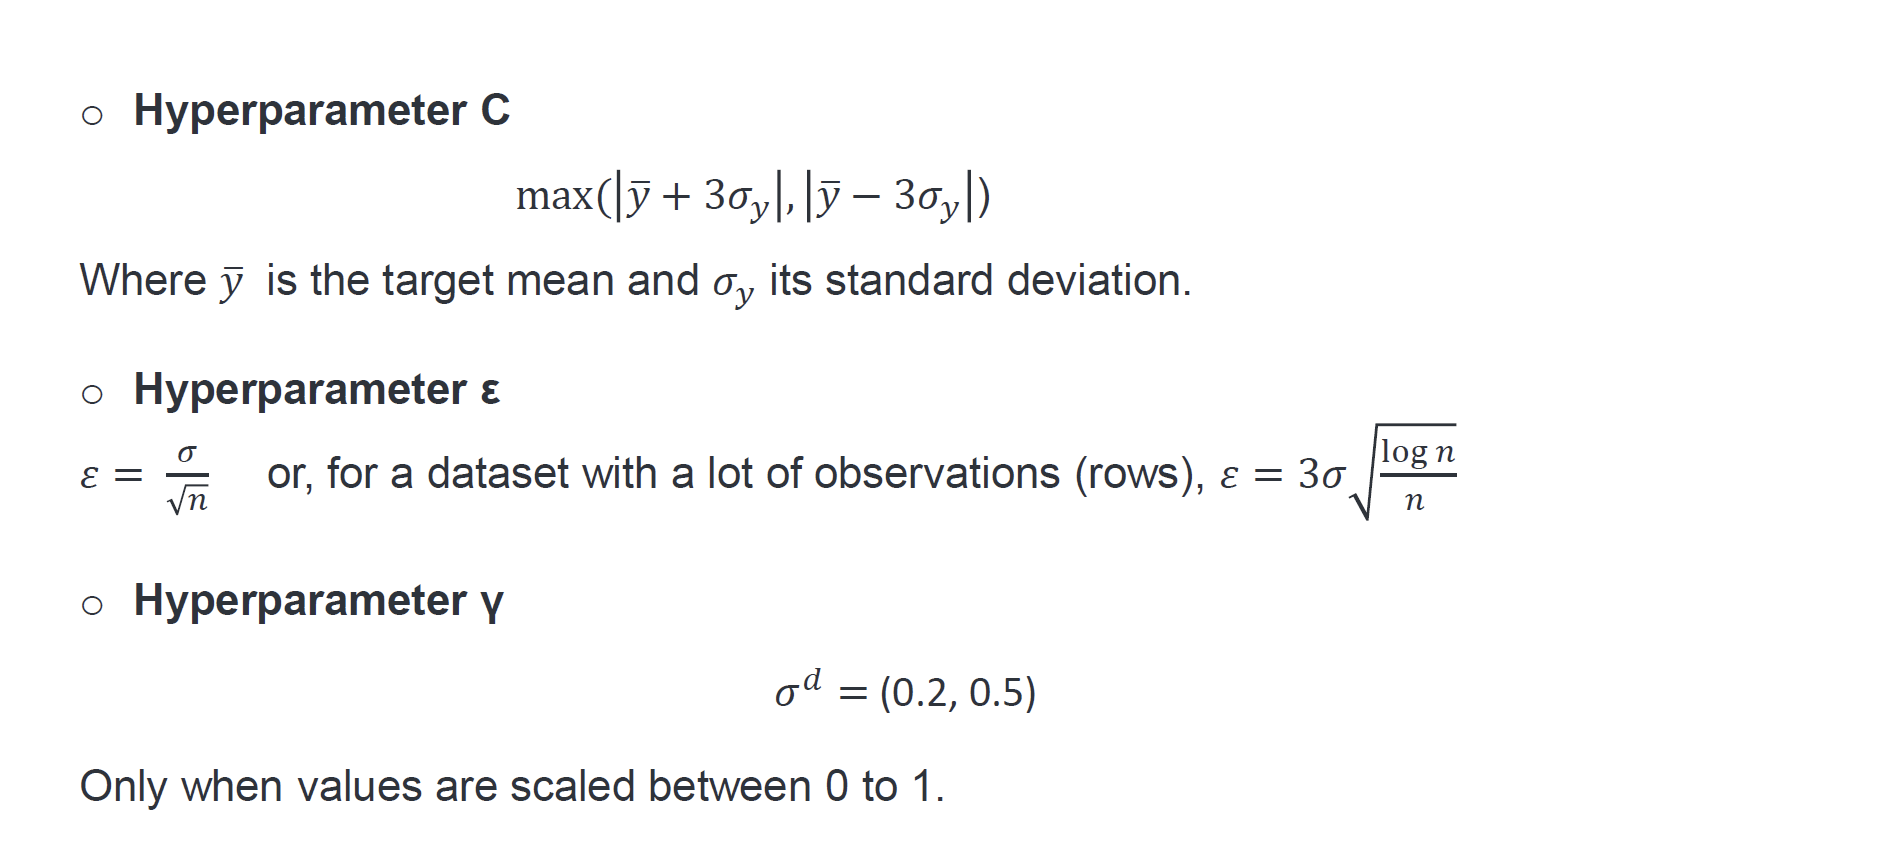

In [5]:
d = X_train.shape[1]
m = np.mean(y_train)
s = np.std(y_train)

In [6]:
C_cherk = np.max([np.abs(m + 3*s),np.abs(m - 3*s)])
gamma_cherk = np.power(0.2, 1/d)

In [32]:
C_cherk

0.6148333425444861

In [33]:
gamma_cherk

0.8177654339579425

Let's define the grid we will be using.

In [7]:
# SVM
C_values = [C_cherk, 1, 1000]
gamma_values = [1e-03, gamma_cherk, 1e03]

params_grid = {'C': C_values,
               'gamma': gamma_values}

Get total number of combinations.

In [8]:
n = len(params_grid['C'])*len(params_grid['gamma'])
print(str(n)+ ' iterations of SVC')

9 iterations of SVC


We will be using **AUC** as evaluation metric.

In [9]:
# 2) Import metric
from sklearn.metrics import roc_auc_score as metric

### Using a Fixed Validation Set

In [ ]:
num_iter = 1;
grid_results = pd.DataFrame(columns = ('C',
                                       'gamma',
                                       'auc_train',
                                       'auc_val',
                                       'time'))

for C in params_grid['C']:
    for gamma in params_grid['gamma']:

                    # Start time
                    start_time = default_timer()

                    # Print trace
                    print('Iteracion = ' + str(num_iter))

                    # [3] Define model
                    model = model_constructor(C = C,
                                              gamma = gamma,
                                              probability = True,
                                              random_state = 0) # Probability = True!!!

                    # [4] Train model
                    model.fit(X_train, y_train)

                    # [5] Predict
                    pred_train = model.predict_proba(X_train) # predict_proba!
                    pred_val = model.predict_proba(X_val) # predict_proba!

                    # [6] Compute metric
                    metric_train = metric(y_train, pred_train[:,0])
                    metric_val = metric(y_val, pred_val[:,0])

                    # Computational time
                    time = default_timer() - start_time

                    # print error
                    print('AUC train = %.2f - AUC validation = %.2f. Time spend = %.2f.'
                          % (metric_train, metric_val, time))

                    # Save iteration results
                    grid_results.loc[num_iter]=[C,
                                                gamma,
                                                metric_train,
                                                metric_val,
                                                time]
                    num_iter += 1

print('Grid Search Total Computational Time: ', np.sum(grid_results.time.values))

Iteracion = 1
AUC train = 0.10 - AUC validation = 0.46. Time spend = 78.37.
Iteracion = 2
AUC train = 0.00 - AUC validation = 0.30. Time spend = 796.06.
Iteracion = 3
AUC train = 0.00 - AUC validation = 0.49. Time spend = 887.92.
Iteracion = 4
AUC train = 0.10 - AUC validation = 0.46. Time spend = 89.08.
Iteracion = 5
AUC train = 0.00 - AUC validation = 0.30. Time spend = 836.00.
Iteracion = 6


Check results

In [ ]:
grid_results

Massive difference in terms of metric. **SVM is very sensitive to choice of hyperparameters**.

Let's select the best model.

In [ ]:
grid_results = grid_results.sort_values(by = ['auc_val', 'auc_train', 'time'], ascending = [False, False, True])
grid_results

In [ ]:
best_model = grid_results.iloc[0]
best_model

## Final Model

Validation has served its purpose, let's combine it with train to get more training data.

In [ ]:
print('Old train data size = ' + str(X_train.shape))
print('Old train target size = ' + str(y_train.shape))

# Combine train and validación
X_train = np.concatenate((X_train, X_val), axis = 0)
y_train = np.concatenate((y_train, y_val), axis = 0)

print('New train data size = ' + str(X_train.shape))
print('New train target size = ' + str(y_train.shape))

Old train data size = (105, 4)
Old train target size = (105,)
New train data size = (127, 4)
New train target size = (127,)


In [ ]:
# [3] Define model
model = model_constructor(C = best_model.C,
                          gamma = best_model.gamma,
                          probability = True,
                          random_state = 0) # probability = True!!!

# [4] Train model
model.fit(X_train, y_train)

# [5] Predict
pred_train = model.predict_proba(X_train)
pred_test = model.predict_proba(X_test)

# [6] Compute metric
metric_train = metric(y_train, pred_train, multi_class = 'ovo')
metric_test = metric(y_test, pred_test, multi_class = 'ovo')



In [ ]:
# print error
print('AUC train = %.2f - AUC test = %.2f'
      % (metric_train, metric_test))

AUC train = 1.00 - AUC test = 1.00
